Begun 20240122

This notebook aims to redo the work done in the previous healpy_test_NewAngleEstimator* notebooks. Each of those notebooks are from when I was still using abs() in the PS calculation instead of np.real(), which was causing nonsense results because it was forcing the ExB spectra to be positive.

This particular notebook will test the healpy sims without noise. I'll make another one to add in noise once I confirm that my power spectrum code can recover the angle without it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Setting universal parameters
kx_cut = 90
ky_cut = 50
lmax = 2500
start_index = 11
stop_index = 47
unpixwin = True
angle_min_deg = -20.0
angle_max_deg = 20.0
num_pts = 10000
camb_file = "/home/zbh5/act_analysis/scripts/camb_19413797_lensedtotcls.dat"

In [3]:
# Load bins from ACT DR4
act_dr4_spectra_root = '/home/zbh5/act_analysis/scripts/dr4_tests/act_dr4_spectra/'
full_bins, full_centers = np.loadtxt(act_dr4_spectra_root+'BIN_ACTPOL_50_4_SC_low_ell', usecols=(0,2), unpack=True)
bins, centers = full_bins[:stop_index], full_centers[:stop_index-1]
print("Finished loading ACT bins")

# Load CAMB spectra
ell,DlTT,DlEE,DlBB,DlTE= np.loadtxt("/home/zbh5/act_analysis/scripts/camb_19413797_lensedtotcls.dat", usecols=(0,1,2,3,4), unpack=True) 
# Note that ell runs from 2 to 5400
# convert Dl to Cl
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
ClEE = DlEE * 2 * np.pi / (ell*(ell+1.))
ClTE = DlTE * 2 * np.pi / (ell*(ell+1.))
ClBB = DlBB * 2 * np.pi / (ell*(ell+1.))
max_ell = int(bins[-1])+2
digitized = np.digitize(ell[:max_ell], bins, right=True)
CAMB_ClEE_binned = np.bincount(digitized, ClEE[:max_ell].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
print("Finished loading CAMB spectra")

Finished loading ACT bins
Finished loading CAMB spectra


In [4]:
# Making healpy sim of unrotated map
NSIDE = 512
print(hp.nside2resol(NSIDE,arcmin=True))
unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),NSIDE)
print(unrot_sim_maps.shape)
CMB_Q = unrot_sim_maps[1]
CMB_U = unrot_sim_maps[2]

6.870972823634812
(3, 3145728)


In [5]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    fit_values = gaussian_fit_moment(angles_deg,norm_sampled_likelihood)
    
    return fit_values

In [6]:
# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim

output_angles = []

rot_degs = np.random.normal(0, 5, size=(10))
print("Input angles are: " + str(rot_degs))
rotated_maps = []
for rot_deg in rot_degs:
    #rot_Q_map = np.cos(np.deg2rad(2*rot_deg))*CMB_Q - np.sin(np.deg2rad(2*rot_deg))*CMB_U
    #rot_U_map = np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_Q_map = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell]
    ClEE_rot = spectra_rotated[1][min_ell:max_ell]
    ClBB_rot = spectra_rotated[2][min_ell:max_ell]
    ClTE_rot = spectra_rotated[3][min_ell:max_ell]
    ClEB_rot = spectra_rotated[4][min_ell:max_ell]
    ClTB_rot = spectra_rotated[5][min_ell:max_ell]
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell-2:max_ell-2],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles.append(fit_values)

Input angles are: [-2.68962923  4.31454805  4.55571446  1.42151088  0.8717651  -3.71580569
 -3.94762682 -0.67472519 -2.50255668 -3.36639069]
Output angle: (1.3301720276968998, 0.06254435434103937)
Output angle: (-2.133782597587441, 0.1004432587008672)
Output angle: (-2.253052210061195, 0.10608015205477117)
Output angle: (-0.7030170119654601, 0.0330386130943915)
Output angle: (-0.4311368929988475, 0.020258950313093858)
Output angle: (1.8376723396902337, 0.08646323129445362)
Output angle: (1.9523203922559391, 0.09187366269195815)
Output angle: (0.33368958294487927, 0.015679467044859147)
Output angle: (1.2376543212004132, 0.058188593162685195)
Output angle: (1.6648676578741974, 0.0783134748653068)


In [9]:
print(rot_degs)
print([output_angle[0] * 2 for output_angle in output_angles])

[-2.68962923  4.31454805  4.55571446  1.42151088  0.8717651  -3.71580569
 -3.94762682 -0.67472519 -2.50255668 -3.36639069]
[2.6603440553937996, -4.267565195174882, -4.50610442012239, -1.4060340239309201, -0.862273785997695, 3.6753446793804674, 3.9046407845118782, 0.6673791658897585, 2.4753086424008264, 3.329735315748395]


Moving on to testing my spectrum code - I am going to move directly to using a real depth-1 mask

In [31]:
keys_eshow = {"downgrade": 2, "ticks": 5, "colorbar": True, "font_size": 40}

def eshow(x,**kwargs): 
    ''' Function to plot the maps for debugging '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "auto")

In [34]:
def load_depth1_with_T(depth1_path,plot=False):
    """
        This function takes the path to a given depth-1 map, loads them
        and the ivar map, and returns the Q, U, and ivar maps as well as the
        shape and wcs of the maps for use in cutting out the right coadd area. 
    """
    
    depth1_maps = enmap.read_map(depth1_path)
    depth1_shape, depth1_wcs = depth1_maps[1].shape, depth1_maps[1].wcs
    
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
    
    if plot:
        eshow(depth1_maps[0], **keys_eshow)
        eshow(depth1_maps[1], **keys_eshow)
        eshow(depth1_maps[2], **keys_eshow)
        eshow(depth1_ivar, **keys_eshow)
    
    return depth1_maps, depth1_ivar, depth1_shape, depth1_wcs

def apply_kspace_filter(maps, kx_cut, ky_cut, unpixwin):
    """
       	Takes in a set of T/Q/U maps that already have a taper applied, apply
        a k-space filter to remove ground pickup, and returns the E and B maps
    """
    singleobs_TEB = enmap.map2harm(maps, normalize = "phys")

    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(singleobs_TEB)):
            wy, wx = enmap.calc_window(singleobs_TEB[i].shape)
            singleobs_TEB[i] /= wy[:, np.newaxis]
            singleobs_TEB[i] /= wx[np.newaxis, :]

    ly, lx = singleobs_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = singleobs_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB

def make_tapered_mask(map_to_mask,filter_radius=1.0, plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def get_tfunc(kx,ky,lmax, bins):
    cut = (ky+kx)*4
    ell = np.arange(lmax)
    tfunc = np.zeros(lmax)
    tfunc[1:] = 1 - cut / (2*np.pi*ell[1:])

    digitized = np.digitize(ell, bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    tfunc_binned = np.bincount(digitized, tfunc.reshape(-1))[1:-1]/bincount
    return tfunc_binned

def spectrum_from_maps(map1, map2, b_ell_bin_1, b_ell_bin_2, w2, bins):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))

    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2

    modlmap = map1.modlmap()

    # Bin the power spectrum
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= (b_ell_bin_1*b_ell_bin_2)

    return binned, bincount

In [103]:
# Loading list of depth-1 maps
obs_list = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt'
obs_list_path = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/"
with open(obs_list) as f:
    lines = f.read().splitlines()

print(lines[0])
# Loading in a depth-1 map and ivar to use for mask
depth1_maps, depth1_ivar, shape, wcs = load_depth1_with_T(obs_list_path + lines[0], plot=False)
# Generate mask
depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)

depth1_1494463440_pa4_f150_map.fits


In [104]:
filtering = False
ivar_weight = True
use_tfunc = False
use_beam = False

# Make a series of 10 maps with random rotations and recover angles
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim
# Need to get the appropriate group of ACT bins for this max_ell
max_index = np.where(bins < max_ell)[0][-1]
bins_ps = bins[0:max_index]
centers_ps = centers[0:max_index-1]

max_ell = int(bins_ps[-1])+2
digitized = np.digitize(ell[:max_ell], bins_ps, right=True)
CAMB_ClEE_binned_ps = np.bincount(digitized, ClEE[:max_ell].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]

output_angles_ps = []

rot_degs_ps = np.random.normal(0, 5, size=(1))
print("Input angles are: " + str(rot_degs_ps))
for rot_deg in rot_degs_ps:
    rot_Q_map_ps = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map_ps = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps_ps = (unrot_sim_maps[0],rot_Q_map_ps,rot_U_map_ps)

    # Converting to pixell
    rot_pixell_maps = reproject.healpix2map(rot_sim_maps_ps, shape, wcs)
    unrot_pixell_maps = reproject.healpix2map(unrot_sim_maps, shape, wcs)
    #eshow(rot_pixell_maps[1], **keys_eshow)
    #eshow(rot_pixell_maps[2], **keys_eshow)
    #eshow(unrot_pixell_maps[1], **keys_eshow)
    
    # Filter - will filter both the rotated and unrotate maps
    if filtering: # Returns TEB
        rot_pixell_maps_TEB = apply_kspace_filter(rot_pixell_maps*depth1_mask, kx_cut, ky_cut, unpixwin=True)
        unrot_pixell_maps_TEB = apply_kspace_filter(rot_pixell_maps*depth1_mask, kx_cut, ky_cut, unpixwin=True)
    else: # Just get TEB without filtering
        rot_pixell_maps_TEB = enmap.map2harm(rot_pixell_maps*depth1_mask, normalize = "phys")
        unrot_pixell_maps_TEB = enmap.map2harm(unrot_pixell_maps*depth1_mask, normalize = "phys")
    
    # Ivar weight
    if ivar_weight:
        # Rot maps
        rot_pixell_maps_realspace = enmap.harm2map(rot_pixell_maps_TEB, normalize = "phys")
        #eshow(rot_pixell_maps_realspace[1], **keys_eshow)
        rot_pixell_maps_ivar = enmap.zeros((3,) + rot_pixell_maps_realspace[0].shape, wcs=rot_pixell_maps_realspace[0].wcs)
        rot_pixell_maps_ivar[0] = rot_pixell_maps_realspace[0]*2.0*depth1_ivar*depth1_mask # Weighting by the original temperature ivar for T
        rot_pixell_maps_ivar[1] = rot_pixell_maps_realspace[1]*depth1_ivar*depth1_mask
        rot_pixell_maps_ivar[2] = rot_pixell_maps_realspace[2]*depth1_ivar*depth1_mask
          # Converting back to harmonic space
        rot_pixell_maps_TEB = enmap.map2harm(rot_pixell_maps_ivar, normalize = "phys")
        rot_pixell_E = rot_pixell_maps_TEB[1]
        rot_pixell_B = rot_pixell_maps_TEB[2]
        # Unrot maps
        unrot_pixell_maps_realspace = enmap.harm2map(unrot_pixell_maps_TEB, normalize = "phys")
        #eshow(unrot_pixell_maps_realspace[1], **keys_eshow)
        unrot_pixell_maps_ivar = enmap.zeros((3,) + unrot_pixell_maps_realspace[0].shape, wcs=unrot_pixell_maps_realspace[0].wcs)
        unrot_pixell_maps_ivar[0] = unrot_pixell_maps_realspace[0]*2.0*depth1_ivar*depth1_mask # Weighting by the original temperature ivar for T
        unrot_pixell_maps_ivar[1] = unrot_pixell_maps_realspace[1]*depth1_ivar*depth1_mask
        unrot_pixell_maps_ivar[2] = unrot_pixell_maps_realspace[2]*depth1_ivar*depth1_mask
          # Converting back to harmonic space
        unrot_pixell_maps_TEB = enmap.map2harm(unrot_pixell_maps_ivar, normalize = "phys")
        unrot_pixell_E = unrot_pixell_maps_TEB[1]
        unrot_pixell_B = unrot_pixell_maps_TEB[2]
    else:
        rot_pixell_E = rot_pixell_maps_TEB[1]
        rot_pixell_B = rot_pixell_maps_TEB[2]
        unrot_pixell_E = unrot_pixell_maps_TEB[1]
        unrot_pixell_B = unrot_pixell_maps_TEB[2]
        
    # Mask correction
    if ivar_weight:
        w = depth1_ivar*depth1_mask
    else:
        w = depth1_mask
    # Filtering tfunc correction
    if use_tfunc:
        tfunc = get_tfunc(kx_cut, ky_cut, int(bins_ps[-1])+2, bins_ps)
    else:
        tfunc = 1.0
    # Beam correction
    if use_beam:
        ref_beam = 1.0 # Would need to load beam here, but there is no beam for sims? There is some smallest scale
             # because of the resolution of the sim pixels that we might want to account for
    else:
        ref_beam = 1.0
    
    # Calculate spectra
    ell_b = centers_ps
    # Spectra for estimator
    binned_E1xB2, bincount = spectrum_from_maps(rot_pixell_E, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                                b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E2xB1, _ = spectrum_from_maps(rot_pixell_B, unrot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    # Spectra for covariance
    binned_E1xE1, _ = spectrum_from_maps(rot_pixell_E, rot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_B2xB2, _ = spectrum_from_maps(unrot_pixell_B, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E2xE2, _ = spectrum_from_maps(unrot_pixell_E, unrot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_B1xB1, _ = spectrum_from_maps(rot_pixell_B, rot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E1xE2, _ = spectrum_from_maps(rot_pixell_E, unrot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_B1xB2, _ = spectrum_from_maps(rot_pixell_B, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E1xB1, _ = spectrum_from_maps(rot_pixell_E, rot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E2xB2, _ = spectrum_from_maps(unrot_pixell_E, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)    
    # Accounting for transfer function
    binned_E1xB2 /= tfunc**2
    binned_E2xB1 /= tfunc**2
    binned_E1xE1 /= tfunc**2
    binned_B2xB2 /= tfunc**2
    binned_E2xE2 /= tfunc**2
    binned_B1xB1 /= tfunc**2
    binned_E1xE2 /= tfunc**2
    binned_B1xB2 /= tfunc**2
    binned_E1xB1 /= tfunc**2
    binned_E2xB2 /= tfunc**2
    binned_nu = bincount*np.mean(depth1_mask**2) 
    
    # Calculate estimator and covariance
    estimator_ps = binned_E1xB2[start_index:]-binned_E2xB1[start_index:]
    covariance_ps = ((1/binned_nu[start_index:])*((binned_E1xE1[start_index:]*binned_B2xB2[start_index:]+binned_E1xB2[start_index:]**2)
                                +(binned_E2xE2[start_index:]*binned_B1xB1[start_index:]+binned_E2xB1[start_index:]**2)
                                -2*(binned_E1xE2[start_index:]*binned_B1xB2[start_index:]+binned_E1xB1[start_index:]*binned_E2xB2[start_index:])))
    
    fit_values = sample_likelihood_and_fit(estimator_ps,covariance_ps,CAMB_ClEE_binned_ps[start_index:max_index],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles_ps.append(fit_values)

print(binned_nu[start_index:])

Input angles are: [-5.39839643]
Output angle: (2.530551392621458, 0.025131667556203476)
[ 742.8245536   809.98771396  895.28492762  944.31403468 1015.50698466
 1090.72972427 1148.49004218 1216.99646575 1284.83125771 1354.68094449
 1430.5753157  1489.67889681 1558.18532038 1626.69174395 1700.57122035
 1756.98827505]


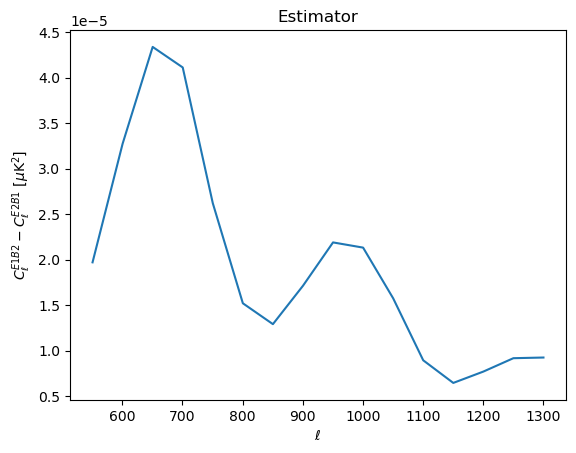

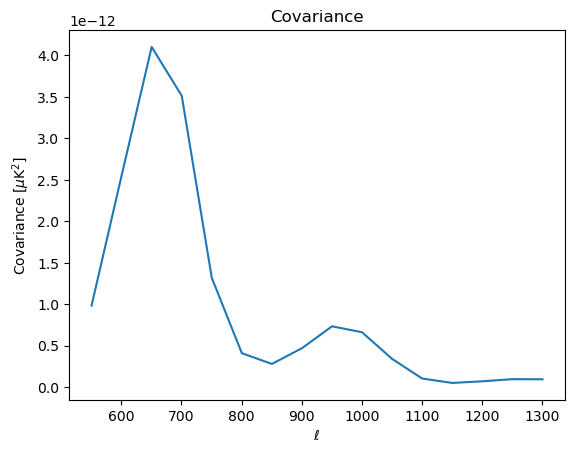

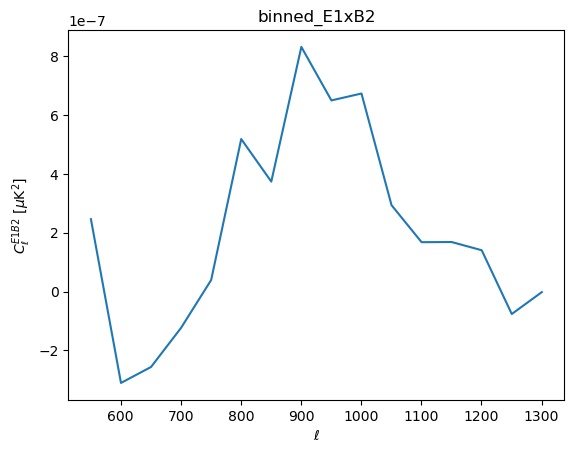

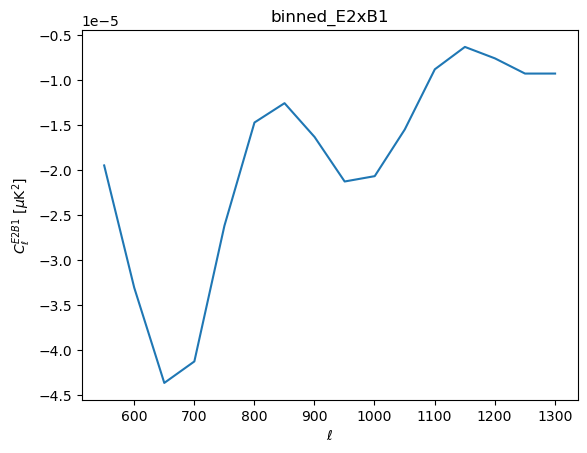

In [106]:
plt.plot(centers_ps[start_index:], estimator_ps)
plt.title("Estimator")
plt.ylabel('$C^{E1B2}_{\ell}-C^{E2B1}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], covariance_ps)
plt.title("Covariance")
plt.ylabel('Covariance [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], binned_E1xB2[start_index:])
plt.title("binned_E1xB2")
plt.ylabel('$C^{E1B2}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], binned_E2xB1[start_index:])
plt.title("binned_E2xB1")
plt.ylabel('$C^{E2B1}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

In [73]:
rot_degs_ps = np.array(rot_degs_ps)
#output_angles_ps = np.array(output_angles_ps)[:,0]
print("Injected rotation angles: ")
print(rot_degs_ps)
print("Calculated angles scaled by -2: ")
print(output_angles_ps * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_ps * -2.0 - rot_degs_ps)/rot_degs_ps)

Injected rotation angles: 
[  1.97179112  -1.41491403 -11.39831502  -0.18254353  -1.27192552
   0.92818154   4.53691249  -5.42725992  -0.63874179   9.19842803]
Calculated angles scaled by -2: 
[  1.84887832  -1.32672975 -10.67947357  -0.17116931  -1.19265577
   0.87033883   4.25366759  -5.08815313  -0.59893814   8.62075825]
Percent difference: 
[-6.23356073 -6.23248296 -6.30655889 -6.23096398 -6.23226346 -6.23183143
 -6.24312027 -6.24821353 -6.23157237 -6.28009242]


In [107]:
# Going to try the same thing (no filtering or tfunc, but using ivar weighting and my PS estimator)
# for a different mask to test the mask effect
# Going to use a mask that covers a wider area with few holes
print(lines[7])
# Loading in a depth-1 map and ivar to use for mask
depth1_maps, depth1_ivar, shape, wcs = load_depth1_with_T(obs_list_path + lines[7], plot=False)
# Generate mask
depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)

filtering = False
ivar_weight = True
use_tfunc = False
use_beam = False

# Make a series of n_maps maps with random rotations and recover angles
n_maps = 1
min_ell = 500
max_ell = 1400 # Can't recover up to more than around here for this resolution of sim
# Need to get the appropriate group of ACT bins for this max_ell
max_index = np.where(bins < max_ell)[0][-1]
bins_ps = bins[0:max_index]
centers_ps = centers[0:max_index-1]

max_ell = int(bins_ps[-1])+2
digitized = np.digitize(ell[:max_ell], bins_ps, right=True)
CAMB_ClEE_binned_ps = np.bincount(digitized, ClEE[:max_ell].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]

output_angles_ps = []

rot_degs_ps = np.random.normal(0, 5, size=(n_maps))
print("Input angles are: " + str(rot_degs_ps))
for rot_deg in rot_degs_ps:
    rot_Q_map_ps = np.cos(np.deg2rad(rot_deg))*CMB_Q - np.sin(np.deg2rad(rot_deg))*CMB_U
    rot_U_map_ps = np.sin(np.deg2rad(rot_deg))*CMB_Q + np.cos(np.deg2rad(rot_deg))*CMB_U
    rot_sim_maps_ps = (unrot_sim_maps[0],rot_Q_map_ps,rot_U_map_ps)

    # Converting to pixell
    rot_pixell_maps = reproject.healpix2map(rot_sim_maps_ps, shape, wcs)
    unrot_pixell_maps = reproject.healpix2map(unrot_sim_maps, shape, wcs)
    #eshow(rot_pixell_maps[1], **keys_eshow)
    #eshow(rot_pixell_maps[2], **keys_eshow)
    #eshow(unrot_pixell_maps[1], **keys_eshow)
    
    # Filter - will filter both the rotated and unrotate maps
    if filtering: # Returns TEB
        rot_pixell_maps_TEB = apply_kspace_filter(rot_pixell_maps*depth1_mask, kx_cut, ky_cut, unpixwin=True)
        unrot_pixell_maps_TEB = apply_kspace_filter(rot_pixell_maps*depth1_mask, kx_cut, ky_cut, unpixwin=True)
    else: # Just get TEB without filtering
        rot_pixell_maps_TEB = enmap.map2harm(rot_pixell_maps*depth1_mask, normalize = "phys")
        unrot_pixell_maps_TEB = enmap.map2harm(unrot_pixell_maps*depth1_mask, normalize = "phys")
    
    # Ivar weight
    if ivar_weight:
        # Rot maps
        rot_pixell_maps_realspace = enmap.harm2map(rot_pixell_maps_TEB, normalize = "phys")
        #eshow(rot_pixell_maps_realspace[1], **keys_eshow)
        rot_pixell_maps_ivar = enmap.zeros((3,) + rot_pixell_maps_realspace[0].shape, wcs=rot_pixell_maps_realspace[0].wcs)
        rot_pixell_maps_ivar[0] = rot_pixell_maps_realspace[0]*2.0*depth1_ivar*depth1_mask # Weighting by the original temperature ivar for T
        rot_pixell_maps_ivar[1] = rot_pixell_maps_realspace[1]*depth1_ivar*depth1_mask
        rot_pixell_maps_ivar[2] = rot_pixell_maps_realspace[2]*depth1_ivar*depth1_mask
          # Converting back to harmonic space
        rot_pixell_maps_TEB = enmap.map2harm(rot_pixell_maps_ivar, normalize = "phys")
        rot_pixell_E = rot_pixell_maps_TEB[1]
        rot_pixell_B = rot_pixell_maps_TEB[2]
        # Unrot maps
        unrot_pixell_maps_realspace = enmap.harm2map(unrot_pixell_maps_TEB, normalize = "phys")
        #eshow(unrot_pixell_maps_realspace[1], **keys_eshow)
        unrot_pixell_maps_ivar = enmap.zeros((3,) + unrot_pixell_maps_realspace[0].shape, wcs=unrot_pixell_maps_realspace[0].wcs)
        unrot_pixell_maps_ivar[0] = unrot_pixell_maps_realspace[0]*2.0*depth1_ivar*depth1_mask # Weighting by the original temperature ivar for T
        unrot_pixell_maps_ivar[1] = unrot_pixell_maps_realspace[1]*depth1_ivar*depth1_mask
        unrot_pixell_maps_ivar[2] = unrot_pixell_maps_realspace[2]*depth1_ivar*depth1_mask
          # Converting back to harmonic space
        unrot_pixell_maps_TEB = enmap.map2harm(unrot_pixell_maps_ivar, normalize = "phys")
        unrot_pixell_E = unrot_pixell_maps_TEB[1]
        unrot_pixell_B = unrot_pixell_maps_TEB[2]
    else:
        rot_pixell_E = rot_pixell_maps_TEB[1]
        rot_pixell_B = rot_pixell_maps_TEB[2]
        unrot_pixell_E = unrot_pixell_maps_TEB[1]
        unrot_pixell_B = unrot_pixell_maps_TEB[2]
        
    # Mask correction
    if ivar_weight:
        w = depth1_ivar*depth1_mask
    else:
        w = depth1_mask
    # Filtering tfunc correction
    if use_tfunc:
        tfunc = get_tfunc(kx_cut, ky_cut, int(bins_ps[-1])+2, bins_ps)
    else:
        tfunc = 1.0
    # Beam correction
    if use_beam:
        ref_beam = 1.0 # Would need to load beam here, but there is no beam for sims? There is some smallest scale
             # because of the resolution of the sim pixels that we might want to account for
    else:
        ref_beam = 1.0
    
    # Calculate spectra
    ell_b = centers_ps
    # Spectra for estimator
    binned_E1xB2, bincount = spectrum_from_maps(rot_pixell_E, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                                b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E2xB1, _ = spectrum_from_maps(rot_pixell_B, unrot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    # Spectra for covariance
    binned_E1xE1, _ = spectrum_from_maps(rot_pixell_E, rot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_B2xB2, _ = spectrum_from_maps(unrot_pixell_B, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E2xE2, _ = spectrum_from_maps(unrot_pixell_E, unrot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_B1xB1, _ = spectrum_from_maps(rot_pixell_B, rot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E1xE2, _ = spectrum_from_maps(rot_pixell_E, unrot_pixell_E, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_B1xB2, _ = spectrum_from_maps(rot_pixell_B, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E1xB1, _ = spectrum_from_maps(rot_pixell_E, rot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)
    binned_E2xB2, _ = spectrum_from_maps(unrot_pixell_E, unrot_pixell_B, b_ell_bin_1=ref_beam, \
                                         b_ell_bin_2=ref_beam, w2=np.mean(w*w), bins=bins_ps)    
    # Accounting for transfer function
    binned_E1xB2 /= tfunc**2
    binned_E2xB1 /= tfunc**2
    binned_E1xE1 /= tfunc**2
    binned_B2xB2 /= tfunc**2
    binned_E2xE2 /= tfunc**2
    binned_B1xB1 /= tfunc**2
    binned_E1xE2 /= tfunc**2
    binned_B1xB2 /= tfunc**2
    binned_E1xB1 /= tfunc**2
    binned_E2xB2 /= tfunc**2
    binned_nu = bincount*np.mean(depth1_mask**2) 
    
    # Calculate estimator and covariance
    estimator_ps = binned_E1xB2[start_index:]-binned_E2xB1[start_index:]
    covariance_ps = ((1/binned_nu[start_index:])*((binned_E1xE1[start_index:]*binned_B2xB2[start_index:]+binned_E1xB2[start_index:]**2)
                                +(binned_E2xE2[start_index:]*binned_B1xB1[start_index:]+binned_E2xB1[start_index:]**2)
                                -2*(binned_E1xE2[start_index:]*binned_B1xB2[start_index:]+binned_E1xB1[start_index:]*binned_E2xB2[start_index:])))
    
    fit_values = sample_likelihood_and_fit(estimator_ps,covariance_ps,CAMB_ClEE_binned_ps[start_index:max_index],angle_min_deg=-30.0,angle_max_deg=30.0,num_pts=50000)
    print("Output angle: " + str(fit_values))
    output_angles_ps.append(fit_values)
    
rot_degs_ps = np.array(rot_degs_ps)
output_angles_only_ps = np.array(output_angles_ps)[:,0]
print("Injected rotation angles: ")
print(rot_degs_ps)
print("Calculated angles scaled by -2: ")
print(output_angles_only_ps * -2.0)
print("Percent difference: ")
print(100.0*(output_angles_only_ps * -2.0 - rot_degs_ps)/rot_degs_ps)

depth1_1494479992_pa5_f150_map.fits
Input angles are: [-5.47557365]
Output angle: (nan, nan)
Injected rotation angles: 
[-5.47557365]
Calculated angles scaled by -2: 
[nan]
Percent difference: 
[nan]


/tmp/ipykernel_29222/3718697723.py:34: RuntimeWarning: invalid value encountered in divide
  norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)


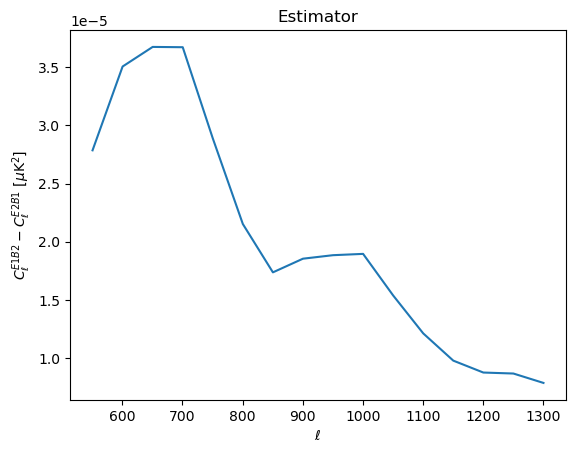

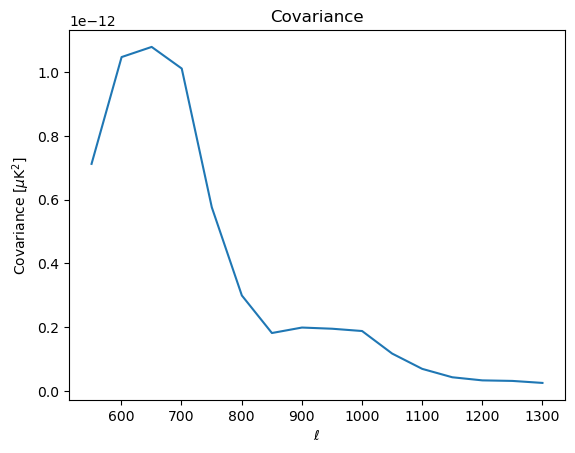

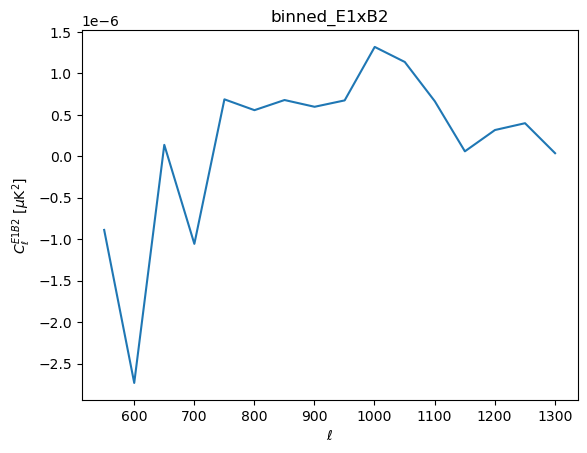

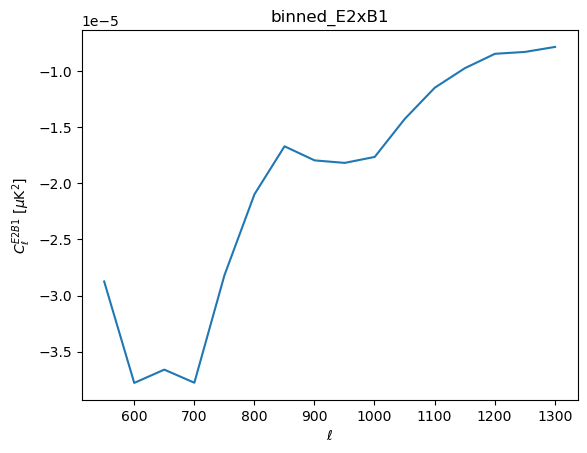

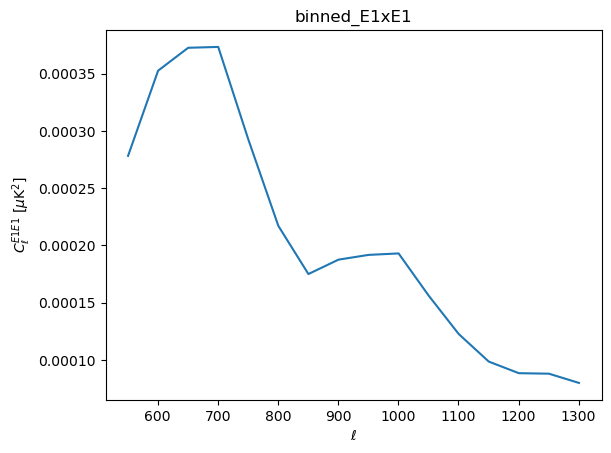

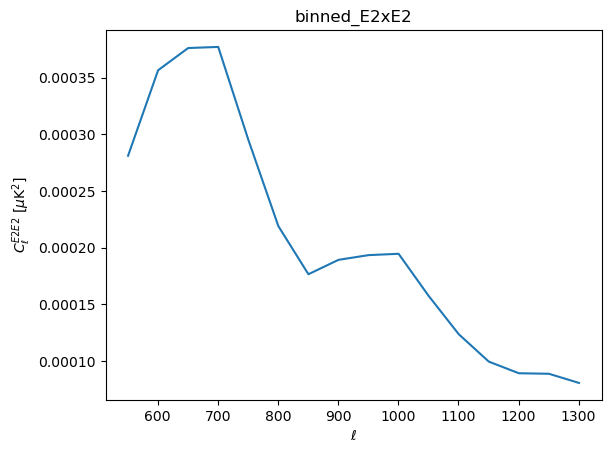

In [108]:
plt.plot(centers_ps[start_index:], estimator_ps)
plt.title("Estimator")
plt.ylabel('$C^{E1B2}_{\ell}-C^{E2B1}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], covariance_ps)
plt.title("Covariance")
plt.ylabel('Covariance [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], binned_E1xB2[start_index:])
plt.title("binned_E1xB2")
plt.ylabel('$C^{E1B2}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], binned_E2xB1[start_index:])
plt.title("binned_E2xB1")
plt.ylabel('$C^{E2B1}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], binned_E1xE1[start_index:])
plt.title("binned_E1xE1")
plt.ylabel('$C^{E1E1}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

plt.plot(centers_ps[start_index:], binned_E2xE2[start_index:])
plt.title("binned_E2xE2")
plt.ylabel('$C^{E2E2}_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

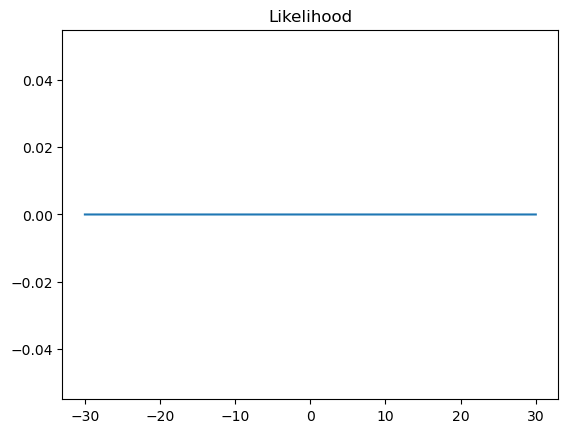

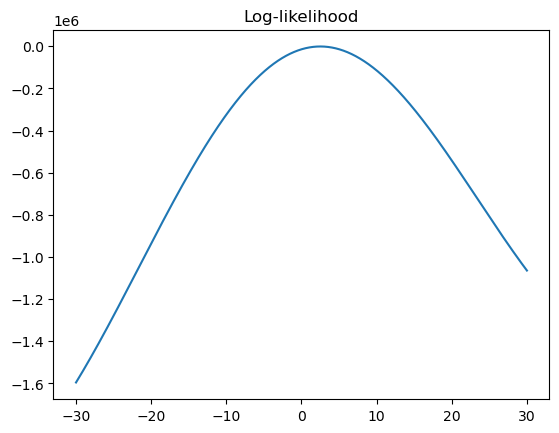

In [111]:
def estimator_likelihood_test(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    loglike = -np.sum(numerator/denominator)
    likelihood = np.exp(loglike)
    return (likelihood, loglike)

angles_deg = np.linspace(-30.0,30.0,num=50000)
angles_rad = np.deg2rad(angles_deg)
    
bin_sampled_likelihood = [estimator_likelihood_test(angle,estimator_ps,covariance_ps,CAMB_ClEE_binned_ps[start_index:max_index])[0] for angle in angles_rad]
loglike = [estimator_likelihood_test(angle,estimator_ps,covariance_ps,CAMB_ClEE_binned_ps[start_index:max_index])[1] for angle in angles_rad]
#plt.plot(angles_deg, bin_sampled_likelihood/(-1.0*np.max(bin_sampled_likelihood)))
plt.plot(angles_deg, bin_sampled_likelihood)
plt.title("Likelihood")
plt.show()
plt.plot(angles_deg, loglike)
plt.title("Log-likelihood")
plt.show()

In [102]:
binned_nu[start_index:]

array([2020.69110374, 2210.70696893, 2386.54254568, 2559.54206474,
       2755.23004531, 2916.88533361, 3125.33557379, 3279.90071786,
       3489.76898688, 3668.44062132, 3852.78437113, 4028.61994788,
       4212.96369769, 4390.21730329, 4581.65119732, 4737.63437024])